<a href="https://colab.research.google.com/github/enoveri/Deep-Learning/blob/main/WasteClassificationWithResnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
from google.colab import drive
import torch
import torch.nn as nn
import matplotlib.pyplot  as plt
import numpy as np
import torchvision
from torchvision import transforms, datasets
from zipfile import ZipFile
from PIL import Image
import random
import os
from torch.utils.data import DataLoader
from torchvision.models import inception_v3, efficientnet_b0, resnet50, mobilenet_v3_small
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time
import pandas as pd

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
BASE_MODEL_TYPE = "resnet50" # supported types: resnet50, inceptionv3, mobilenetv3 , efficientNet, CustomCNN
NUM_EPOCHS = 100
IMAGE_SIZE = (299,299)
NUM_CLASSES = 4
project_folder = Path("/content/drive/MyDrive/ML/Waste")
model_save_path = project_folder/"Best Model"
training_data_path = project_folder/"utilities"
for path in [project_folder,model_save_path,training_data_path]:
    path.mkdir(parents= True, exist_ok = True)


cuda


In [4]:

!pip install gdown
import gdown
waste_data_path = Path("root")
waste_data_path.mkdir(parents = True, exist_ok = True)
data_path = "waste_data.zip"
id = "1-FfLID2UGcco6IsYAeQZUaSC0YtSpP0o"
url = f"https://drive.google.com/uc?id={id}"
gdown.download(url, data_path)
# Open the ZIP file and extract its contents
with ZipFile("/content/waste_data.zip", 'r') as ref:
    ref.extractall(waste_data_path)

Downloading...
From (original): https://drive.google.com/uc?id=1-FfLID2UGcco6IsYAeQZUaSC0YtSpP0o
From (redirected): https://drive.google.com/uc?id=1-FfLID2UGcco6IsYAeQZUaSC0YtSpP0o&confirm=t&uuid=7c78ea8a-260a-44ed-81a0-2b554eaa6ebc
To: /content/waste_data.zip
100%|██████████| 1.35G/1.35G [00:18<00:00, 71.1MB/s]


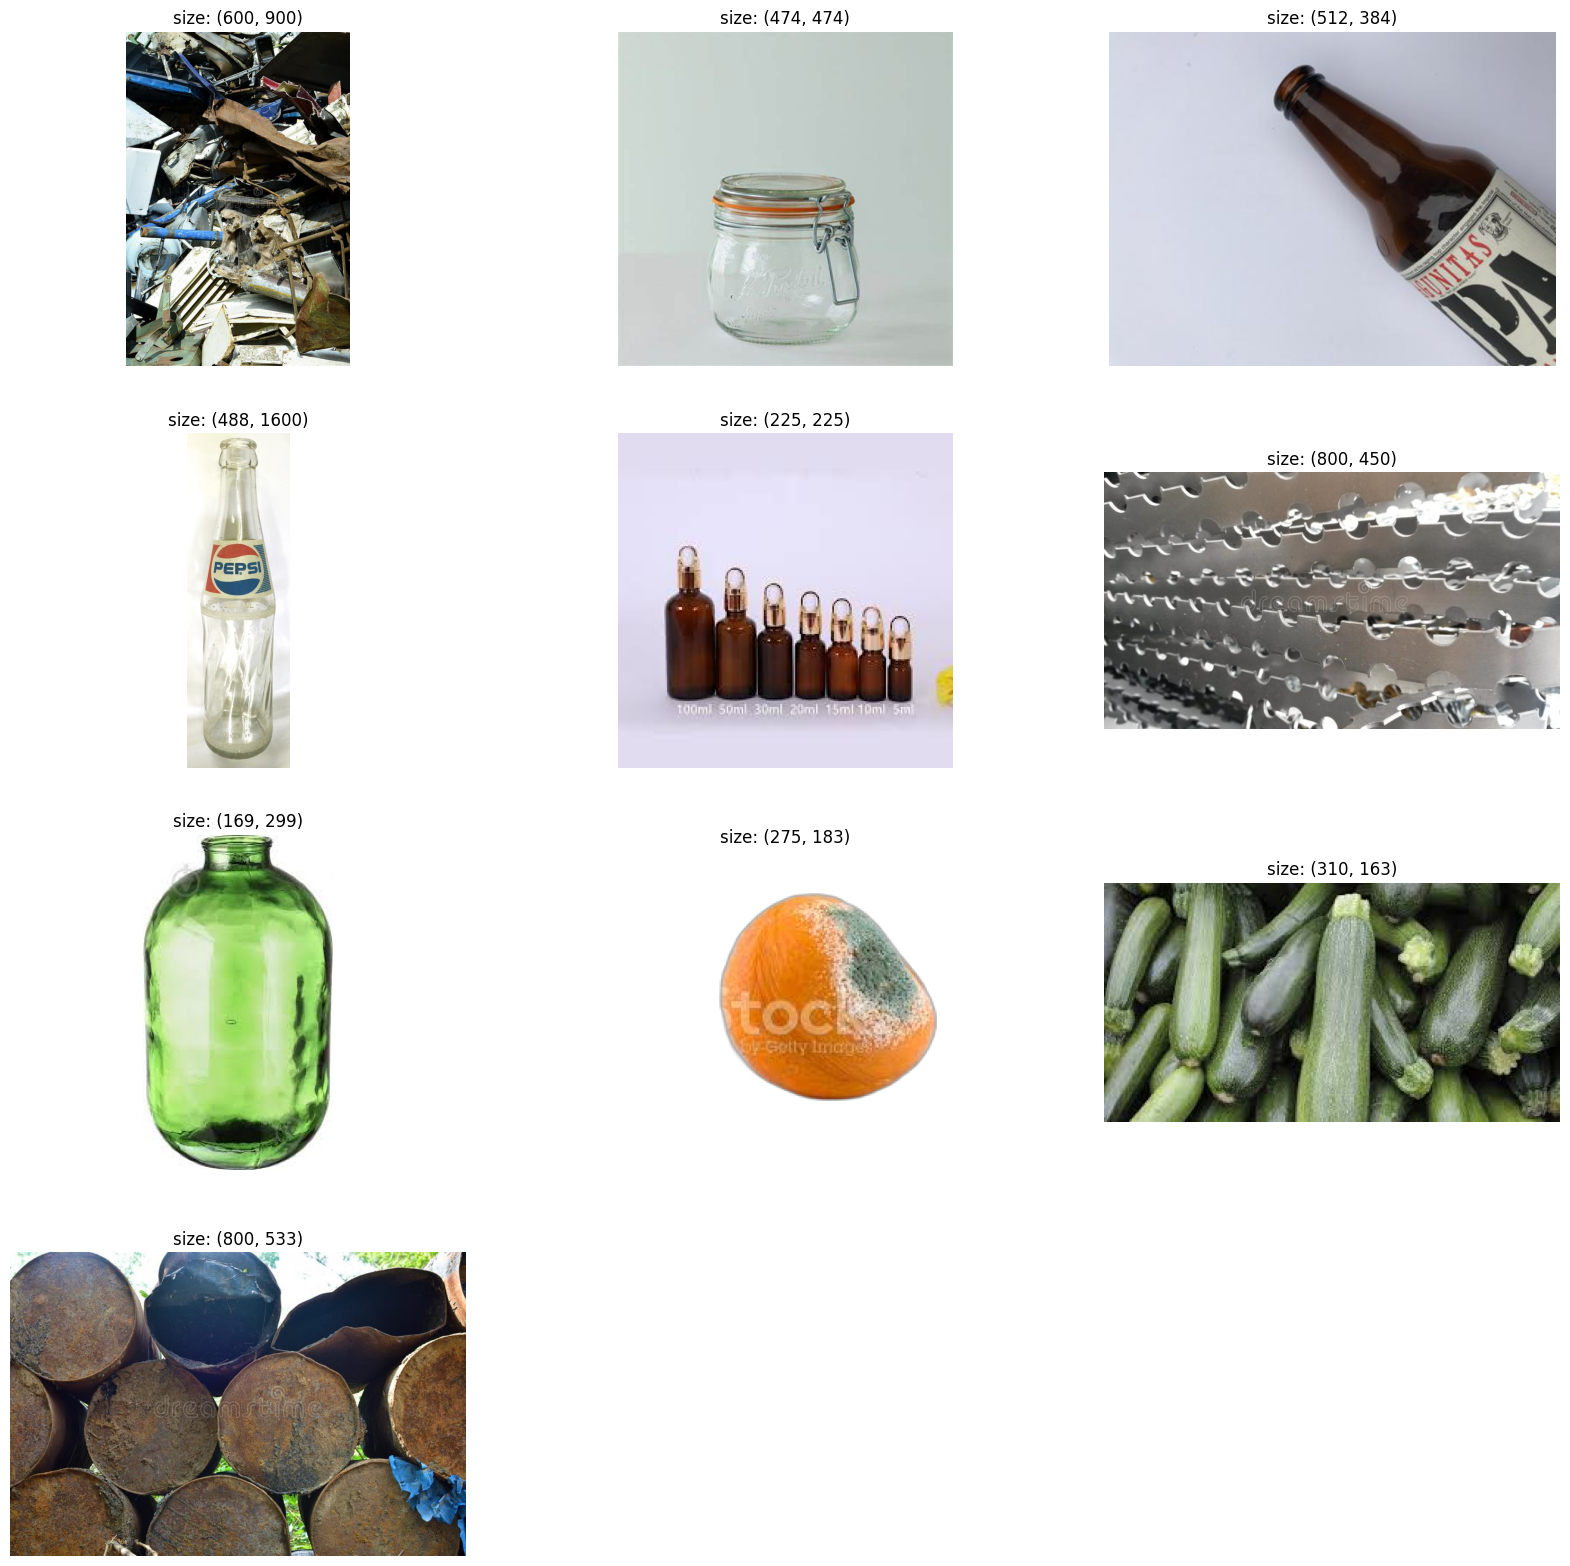

In [5]:
random_images  = list(waste_data_path.rglob("**/*.jpg"))
random.shuffle(random_images)
fig = plt.figure(figsize=(20,20))
for i, image in enumerate(random_images[:10]):

    image = Image.open(image)
    plt.subplot(10//3+1,3,i+1)
    plt.imshow(image)
    plt.title(f"size: {image.size}")
    plt.axis('off')
plt.show()
fig.savefig(project_folder/"random_images.png")



In [25]:
len(random_images)

7222

In [6]:
test_path = waste_data_path/"test"
train_path = waste_data_path/"train"
val_path = waste_data_path/"val"
train_transforms = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
val_test_transforms = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [7]:
train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=train_transforms,
    target_transform=None
)
test_dataset = datasets.ImageFolder(
    root = test_path,
    transform=val_test_transforms,
    target_transform=None
)
val_dataset = datasets.ImageFolder(
    root = val_path,
    transform=val_test_transforms,
    target_transform=None
)

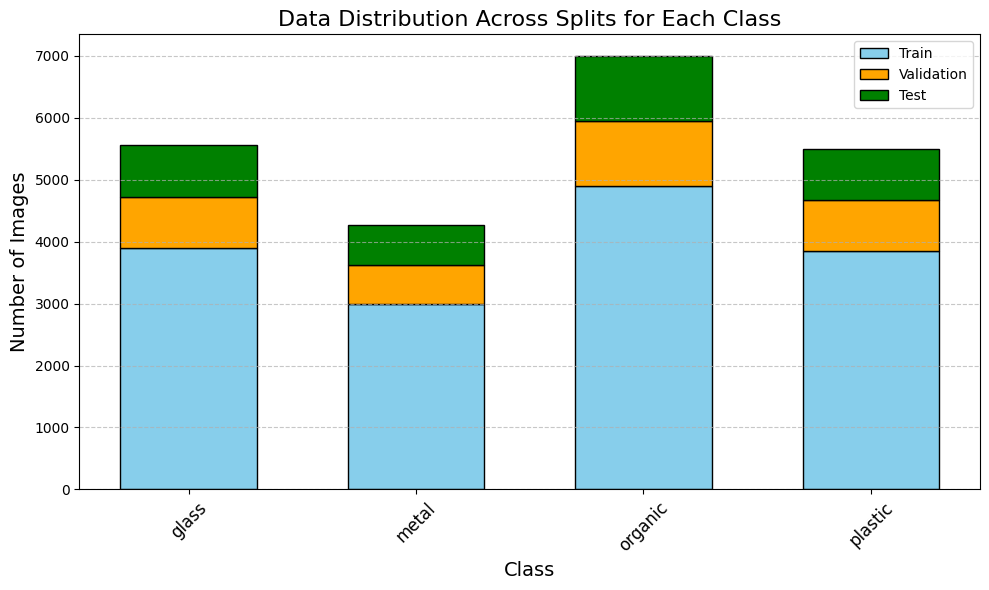

Data split distribution chart saved as: /content/drive/MyDrive/ML/Waste/data_split_distribution.png


In [27]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to count labels in a dataset
def count_labels(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

# Count labels in each split
train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)
test_counts = count_labels(test_dataset)

# Ensure all class indices are represented
all_classes = range(len(class_names))
train_counts = [train_counts[i] for i in all_classes]
val_counts = [val_counts[i] for i in all_classes]
test_counts = [test_counts[i] for i in all_classes]

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.6

# Create stacked bars
train_bars = plt.bar(class_names, train_counts, width=bar_width, label="Train", color="skyblue", edgecolor="black")
val_bars = plt.bar(class_names, val_counts, width=bar_width, bottom=train_counts, label="Validation", color="orange", edgecolor="black")
test_bars = plt.bar(class_names, test_counts, width=bar_width, bottom=[i + j for i, j in zip(train_counts, val_counts)], label="Test", color="green", edgecolor="black")

# Add titles and labels
plt.title("Data Distribution Across Splits for Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save and display the plot
plt.savefig(project_folder / "data_split_distribution.png")
plt.show()

print(f"Data split distribution chart saved as: {project_folder / 'data_split_distribution.png'}")


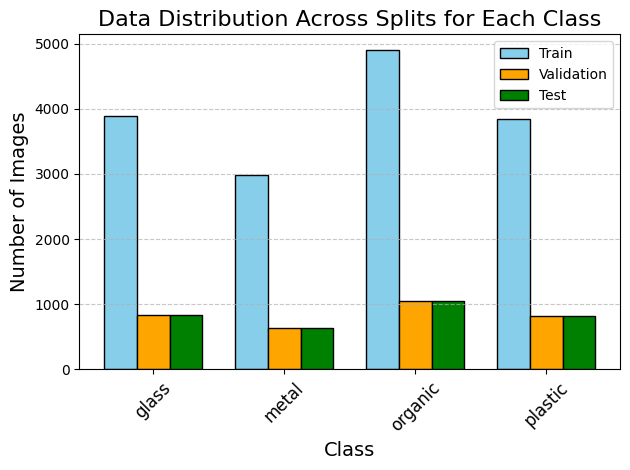

Grouped data split distribution chart saved as: /content/drive/MyDrive/ML/Waste/grouped_data_split_distribution.png


In [31]:
x = np.arange(len(class_names))  # Class positions
bar_width = 0.25  # Width of each bar
class_names = train_dataset.classes
plt.bar(x - bar_width, train_counts, width=bar_width, label="Train", color="skyblue", edgecolor="black")
plt.bar(x, val_counts, width=bar_width, label="Validation", color="orange", edgecolor="black")
plt.bar(x + bar_width, test_counts, width=bar_width, label="Test", color="green", edgecolor="black")

# Add labels, title, and grid
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Data Distribution Across Splits for Each Class", fontsize=16)
plt.xticks(ticks=x, labels=class_names, fontsize=12, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save and display the plot
plt.savefig(project_folder / "grouped_data_split_distribution.png")
plt.show()

print(f"Grouped data split distribution chart saved as: {project_folder / 'grouped_data_split_distribution.png'}")

In [8]:
from torch.utils.data import DataLoader
train_dataLoader = DataLoader(
    dataset = train_dataset,
    batch_size= 64,
    shuffle= True,
    num_workers=os.cpu_count(),
    pin_memory=True
)
test_dataLoader = DataLoader(
    dataset = test_dataset,
    batch_size= 64,
    shuffle= False,
    num_workers=os.cpu_count(),
    pin_memory=True
)
val_dataLoader = DataLoader(
    dataset = val_dataset,
    batch_size= 64,
    shuffle= False,
    num_workers=os.cpu_count(),
    pin_memory=True
)

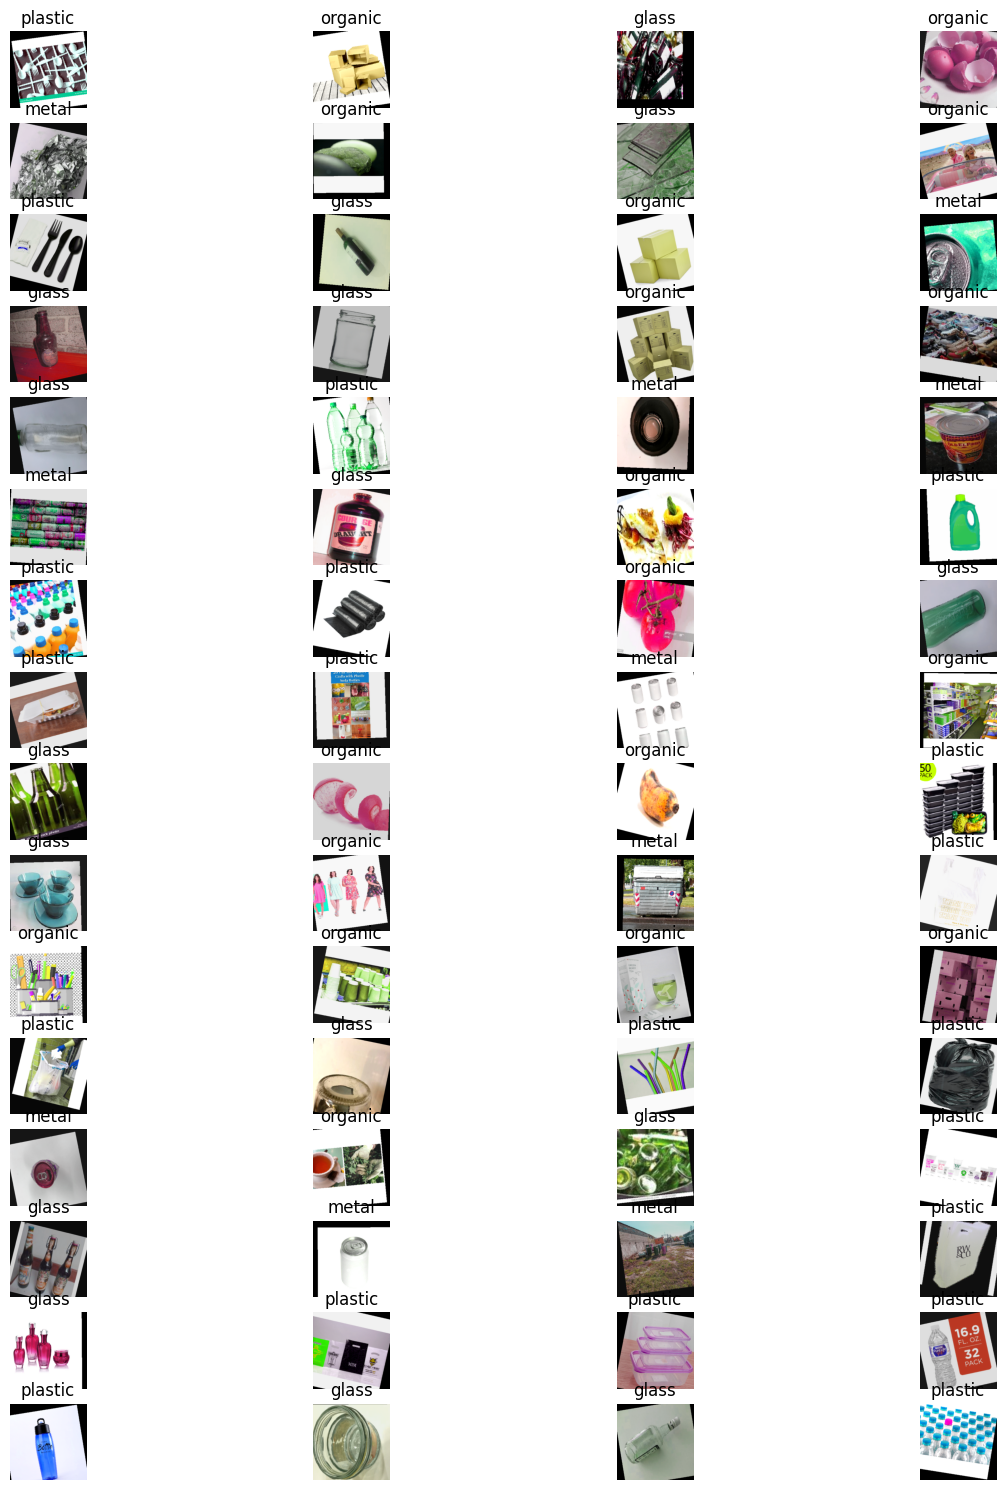

In [9]:
images, labels = next(iter(train_dataLoader))
class_names = train_dataset.classes
column_count = 4
row_count = len(images) // column_count + 1
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
fig = plt.figure(figsize = (15, 20))
for idx, (image, label) in enumerate(zip(images, labels)):
    image  = image.cpu().numpy().transpose((1, 2, 0))
    image = std*image + mean
    plt.subplot(row_count, column_count, idx+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")

plt.show()
fig.savefig(project_folder/"data_images.png")

In [10]:
class WasteClfModel(nn.Module):
    def __init__(self, base_model_type, num_classes):
        super().__init__()
        self.base_model_type = base_model_type

        # Load the pretrained base model
        if self.base_model_type == "inceptionv3":
            self.base_model = inception_v3(pretrained=True, aux_logits=False)
            self.base_model.fc = nn.Linear(in_features=2048, out_features=num_classes)

        elif self.base_model_type == "resnet50":
            self.base_model = resnet50(pretrained=True)
            self.base_model.fc = nn.Linear(in_features=2048, out_features=num_classes)

        elif self.base_model_type == "efficientNet":
            self.base_model = efficientnet_b0(pretrained=True)
            self.base_model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)

        elif self.base_model_type == "mobilenetv3":
            self.base_model = mobilenet_v3_small(pretrained=True)
            self.base_model.classifier[3] = nn.Linear(in_features=1024, out_features=num_classes)

        else:
            raise ValueError(f"Unsupported base model type: {self.base_model_type}")

        # Freeze feature extractor layers
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze classification layers
        if self.base_model_type == "inceptionv3":
            for param in self.base_model.fc.parameters():
                param.requires_grad = True
        elif self.base_model_type == "resnet50":
            for param in self.base_model.fc.parameters():
                param.requires_grad = True
        elif self.base_model_type == "efficientNet":
            for param in self.base_model.classifier[1].parameters():
                param.requires_grad = True
        elif self.base_model_type == "mobilenetv3":
            for param in self.base_model.classifier[3].parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)


In [11]:
# Initialize the model
model = WasteClfModel(base_model_type=BASE_MODEL_TYPE, num_classes=NUM_CLASSES)

# Move the model to GPU
model.to(device)

# Check trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.5MB/s]


Trainable: base_model.fc.weight
Trainable: base_model.fc.bias


In [12]:
def train_(model, dataloader, loss_fn, optimizer):
    """
    Perform one epoch of training.

    Args:
        model: The PyTorch model to train.
        dataloader: DataLoader for training data.
        loss_fn: Loss function.
        optimizer: Optimizer.

    Returns:
        train_loss: Average training loss for the epoch.
        train_acc: Training accuracy for the epoch.
    """
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, y_pred_class = torch.max(y_pred, dim=1)
        correct += (y_pred_class == y).sum().item()
        total += y.size(0)

    train_loss /= len(dataloader)
    train_acc = correct / total

    return train_loss, train_acc


In [13]:
def validate_(model, dataloader, loss_fn):
    """
    Perform validation.

    Args:
        model: The PyTorch model to validate.
        dataloader: DataLoader for validation data.
        loss_fn: Loss function.

    Returns:
        val_loss: Average validation loss.
        val_acc: Validation accuracy.
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Compute accuracy
            _, y_pred_class = torch.max(y_pred, dim=1)
            correct += (y_pred_class == y).sum().item()
            total += y.size(0)

    val_loss /= len(dataloader)
    val_acc = correct / total

    return val_loss, val_acc


In [14]:
def train_loop(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs, device, project_folder):
    """
    Training loop function for managing the complete training process with support for resumption.

    Args:
        model: The PyTorch model to train.
        train_dataloader: DataLoader for training data.
        val_dataloader: DataLoader for validation data.
        loss_fn: Loss function.
        optimizer: Optimizer.
        num_epochs: Total number of epochs.
        device: The device to run training on.
        project_folder: Base folder for saving models and results.

    Returns:
        history: Dictionary containing training and validation metrics per epoch.
    """
    # Paths for saving training results and model checkpoints
    results_path = project_folder / "training_results.csv"
    checkpoint_path = project_folder / "checkpoint.pth"
    best_model_path = project_folder / "best_model.pth"

    # Initialize history dictionary
    history = {
        "Epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "training_time": []
    }

    # Attempt to load existing training state
    start_epoch = 0
    best_val_acc = 0.0

    if checkpoint_path.exists():
        print("Resuming from checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint['best_val_acc']
        history_df = pd.read_csv(results_path)
        for key in history:
            history[key] = history_df[key].tolist()

    print(f"Starting training from epoch {start_epoch + 1}")

    for epoch in range(start_epoch, num_epochs):
        start_time = time.time()

        # Training phase
        train_loss, train_acc = train_(model, train_dataloader, loss_fn, optimizer)

        # Validation phase
        val_loss, val_acc = validate_(model, val_dataloader, loss_fn)

        # Record metrics
        epoch_time = time.time() - start_time
        history["Epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["training_time"].append(epoch_time)

        # Save history to CSV
        history_df = pd.DataFrame(history)
        history_df.to_csv(results_path, index=False)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved.")

        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc
        }, checkpoint_path)

        # Display metrics
        tqdm.write(
            f"Epoch {epoch + 1}/{num_epochs} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s"
        )

        # Progress bar
        with tqdm(total=num_epochs, desc="Training Progress", position=0, leave=True) as pbar:
            pbar.update(epoch + 1 - start_epoch)

    print("Training complete.")
    return history


In [15]:
# #Training
history = train_loop(model, train_dataLoader, val_dataLoader, loss_fn, optimizer, NUM_EPOCHS, device, project_folder)

Resuming from checkpoint...


<ipython-input-14-77b89ba6b767>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Starting training from epoch 101
Training complete.


In [16]:
def load_best_model(model, best_model_path, device):
    """
    Load the saved best model from a file.

    Args:
        model: The PyTorch model instance to load weights into.
        best_model_path: Path to the saved best model file (.pth).
        device: Device to map the model onto (CPU or GPU).

    Returns:
        model: The model with loaded weights.
    """
    if best_model_path.exists():
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        model.to(device)
        print(f"Best model loaded from {best_model_path}")
    else:
        raise FileNotFoundError(f"Model file not found at {best_model_path}")
    return model


best_model_path = Path("/content/drive/MyDrive/ML/Waste/best_model.pth")
model = load_best_model(model, best_model_path, device)



<ipython-input-16-2e0f1f2b0e00>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


Best model loaded from /content/drive/MyDrive/ML/Waste/best_model.pth


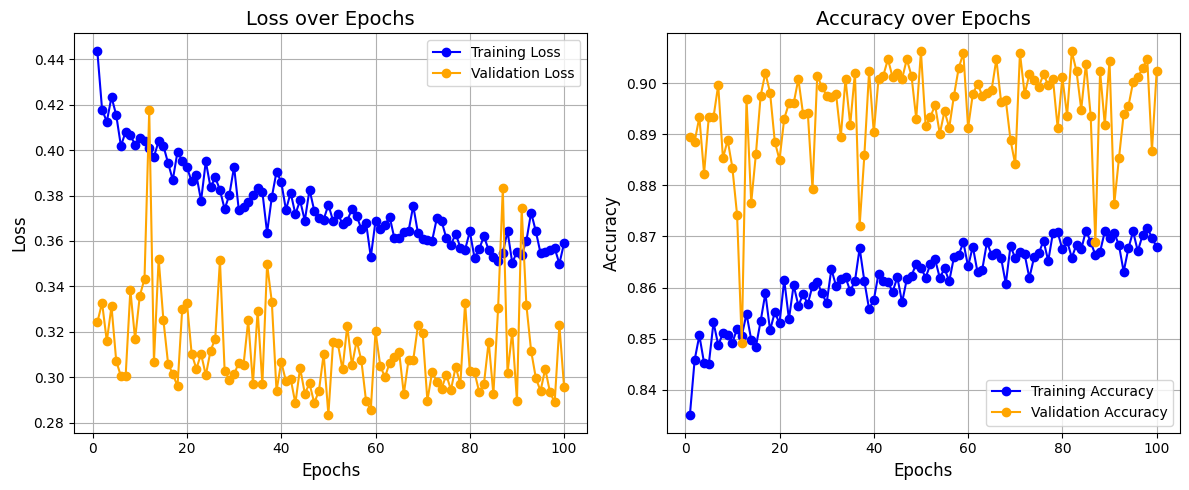

In [17]:
def plot_training_history(history_path):
    """
    Plots training and validation loss and accuracy over epochs.

    Args:
        history (dict): Dictionary containing training and validation metrics.
                        Keys should include 'Epoch', 'train_loss', 'val_loss',
                        'train_acc', and 'val_acc'.

    Returns:
        None
    """
    history_path = Path(history_path)
    if not history_path.exists():
        raise FileNotFoundError(f"History file not found at {history_path}")
    history = pd.read_csv(history_path)
    epochs = history["Epoch"]
    train_loss = history["train_loss"]
    val_loss = history["val_loss"]
    train_acc = history["train_acc"]
    val_acc = history["val_acc"]

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o')
    plt.title("Loss over Epochs", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
    plt.title("Accuracy over Epochs", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history("/content/drive/MyDrive/ML/Waste/training_results.csv")


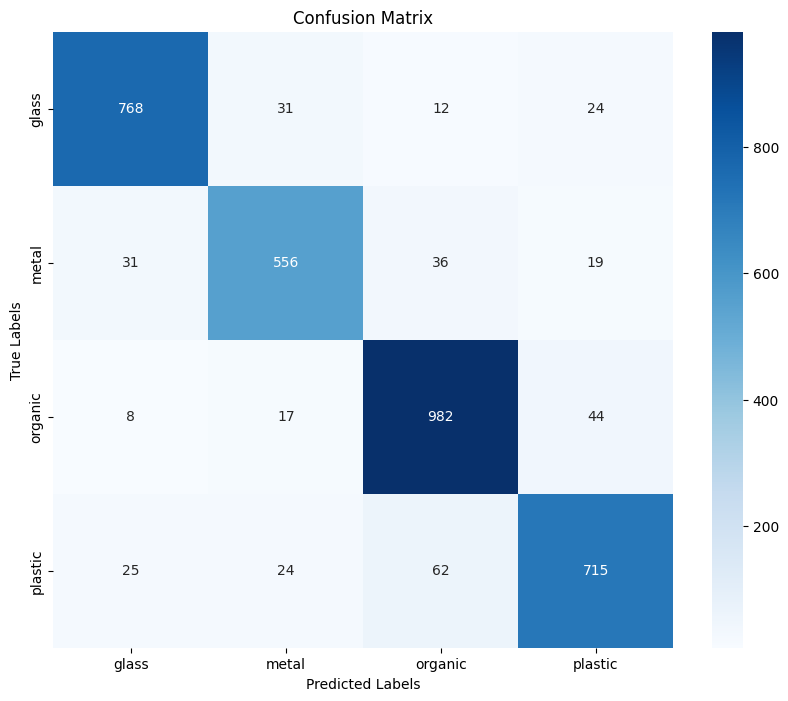

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, dataloader, device, class_names, report_file="/content/drive/MyDrive/ML/Waste/utilities/classification_report.txt"):
    """
    Evaluate the model's performance on the test/validation dataset and save the classification report.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for evaluation data.
        device: Device to perform computations on (CPU or GPU).
        class_names: List of class names.
        report_file: Path to save the classification report.

    Returns:
        None
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_class = torch.argmax(y_pred, dim=1)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(y_pred_class.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names)
    with open(report_file, "w") as f:
        f.write(report)

    cm = confusion_matrix(all_labels, all_preds)
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    fig.savefig("/content/drive/MyDrive/ML/Waste/utilities/Confusion_matrix.png")

evaluate_model(model, test_dataLoader, device, class_names)


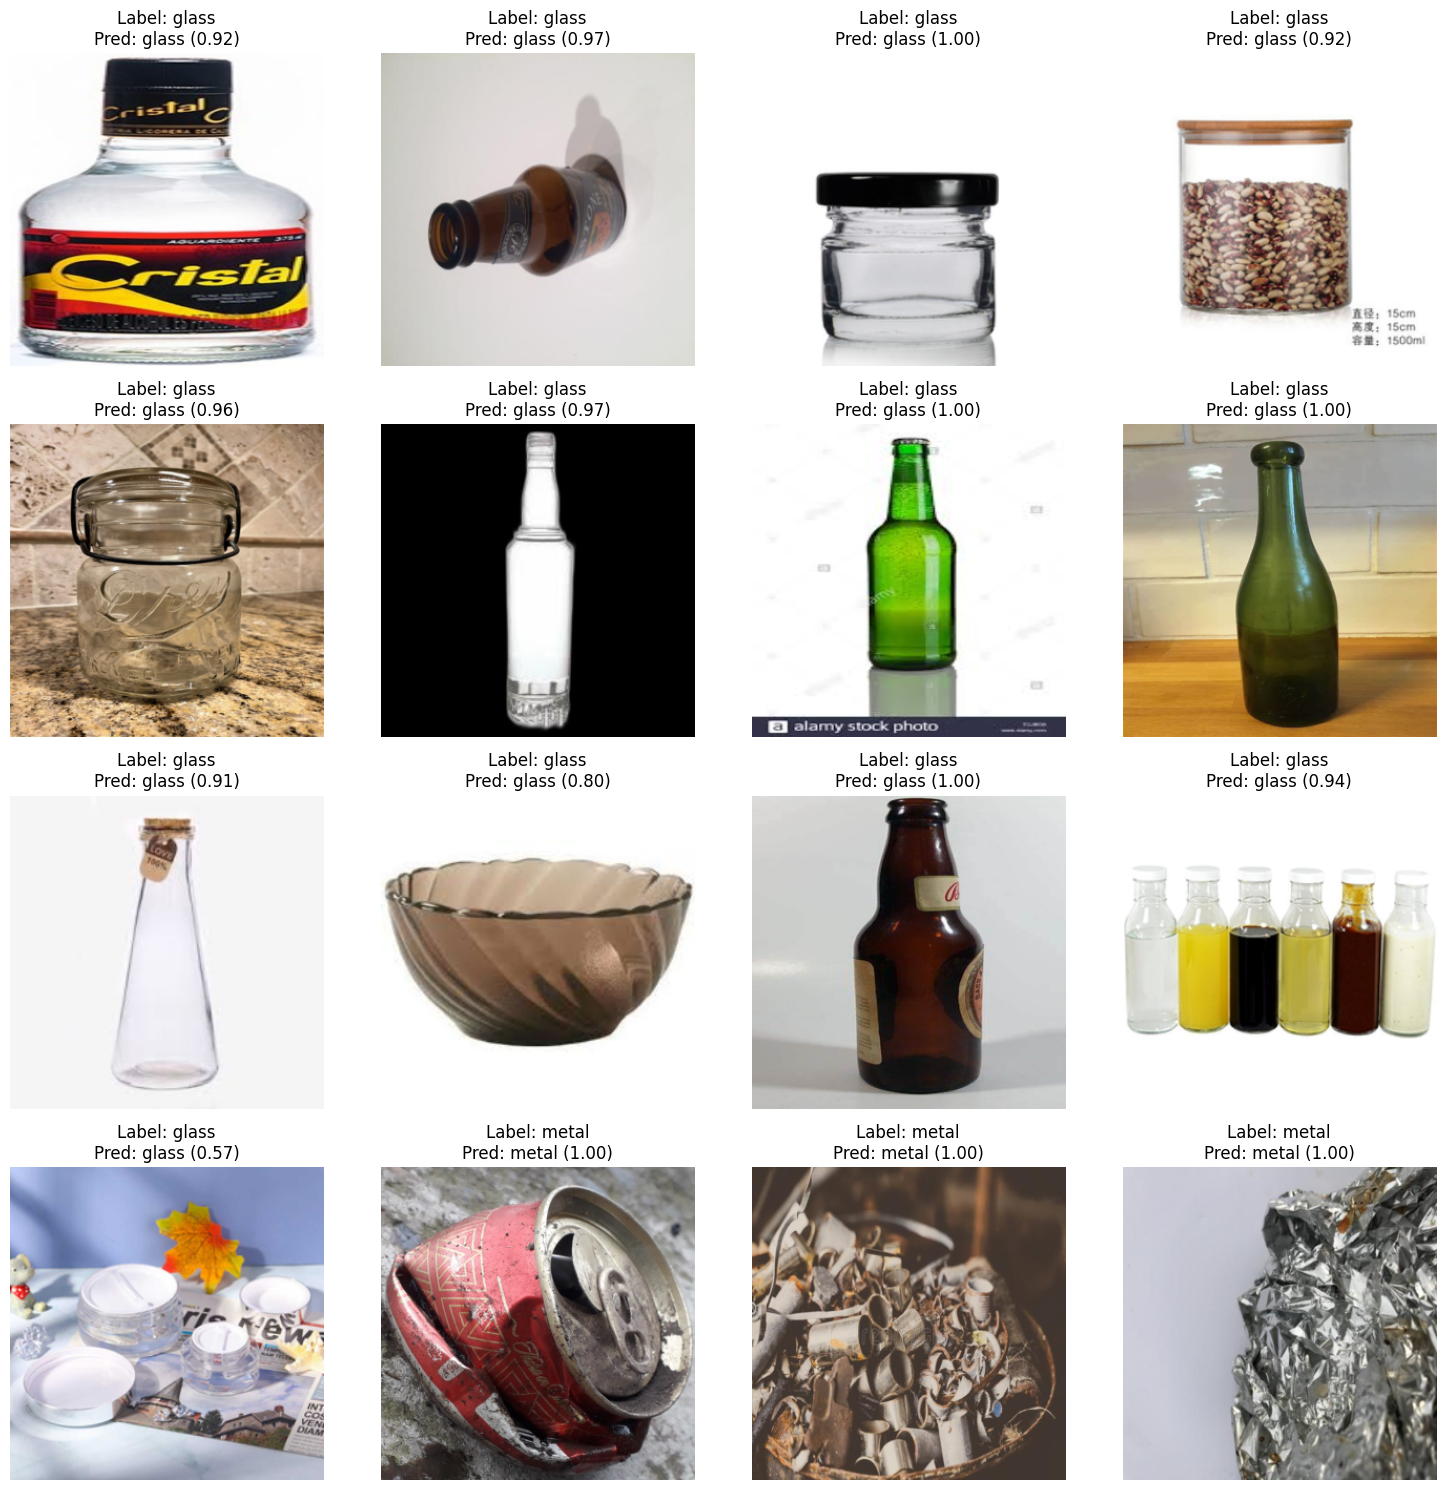

In [19]:
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions_with_confidence(model, dataloader, class_names, device):
    """
    Visualize predictions made by the model on test data, with confidence levels.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for test data.
        class_names: List of class names.
        device: Device to perform computations on (CPU or GPU).

    Returns:
        None. Displays a grid of images with predictions, labels, and confidence levels.
    """

    model.eval()
    selected_images = []
    selected_labels = []

    for images, labels in dataloader:
        idx = random.randint(0, len(images) - 1)
        selected_images.append(images[idx])
        selected_labels.append(labels[idx])

    selected_images = torch.stack(selected_images).to(device)
    selected_labels = torch.tensor(selected_labels).to(device)

    with torch.inference_mode():
        predictions = model(selected_images)
        probabilities = F.softmax(predictions, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        confidences = probabilities.max(dim=1).values

    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    images = selected_images.cpu().numpy().transpose((0, 2, 3, 1))
    images = (images * std) + mean
    images = np.clip(images, 0, 1)

    fig = plt.figure(figsize=(15, 15))
    for i in range(min(len(images), 16)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        title = (
            f"Label: {class_names[selected_labels[i]]}\n"
            f"Pred: {class_names[predicted_classes[i]]} "
            f"({confidences[i]:.2f})"
        )
        if predicted_classes[i] != selected_labels[i]:
            plt.title(title, color="red")
        else:
            plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    fig.savefig("/content/drive/MyDrive/ML/Waste/utilities/Test_data_predictions.png")

# Example usage
visualize_predictions_with_confidence(model, test_dataLoader, class_names, device)


In [20]:
class_names= test_dataset.classes
class_names

['glass', 'metal', 'organic', 'plastic']

<ipython-input-16-2e0f1f2b0e00>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


Best model loaded from /content/drive/MyDrive/ML/Waste/best_model.pth


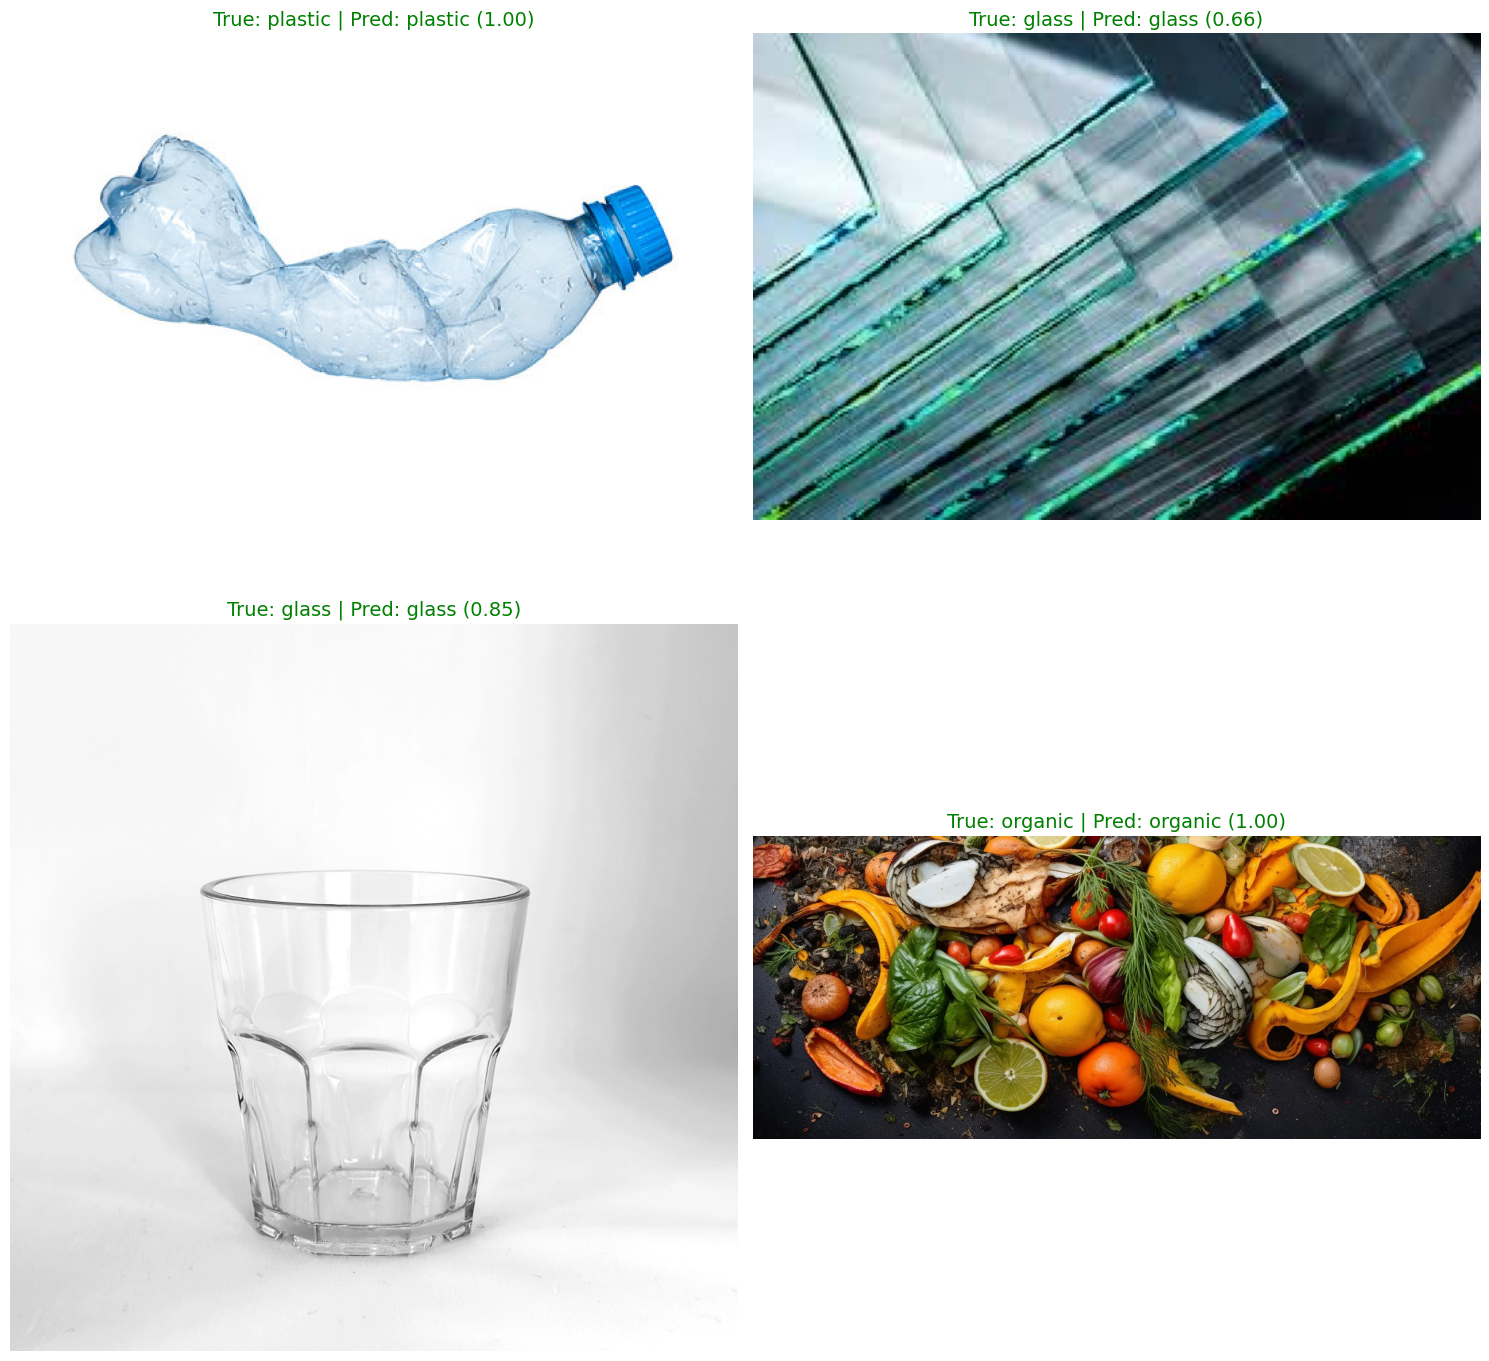

In [21]:
from PIL import Image
import requests
from io import BytesIO
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the image URLs and their corresponding true labels
image_data = [
    {"url": "https://t4.ftcdn.net/jpg/04/98/36/27/360_F_498362712_7sJRmv7sOsfCtqieE0wtIjUpdUBvF4PY.jpg",
     "label": "plastic"},
    {"url": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRbuHf0KMchEhmL-XjpYTmmcwW_xUt9XPZhQ&s",
     "label": "glass"},
    {"url": "https://healsafeinterior.com/wp-content/uploads/2020/12/Glass-25-cl_white_1000x1000_2.webp",
     "label": "glass"},
    {"url": "https://sodali.com/media/insights/3012/conversions/tackling-food-loss-and-waste-in-japan-thumb.webp",
     "label": "organic"}
]

# Define the image transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Load the model
model = load_best_model(model, best_model_path, device)  # Ensure this function is implemented
model.eval()

# Function to load an image from a URL
def load_image(url):
    response = requests.get(url)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

# Function to predict the class of an image
def predict_image(model, image, transform, class_names, device):
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        predicted_label = class_names[predicted_idx.item()]
    return predicted_label, confidence.item()

# Class names from the test dataset
class_names = test_dataset.classes  # Ensure `test_dataset` is defined

# Set up the figure for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()  # Flatten for easy iteration over axes

# Evaluate the model on the custom images
for idx, data in enumerate(image_data):
    try:
        img = load_image(data["url"])
    except requests.exceptions.RequestException as e:
        print(f"Error loading image from {data['url']}: {e}")
        continue

    predicted_label, confidence = predict_image(model, img, transform, class_names, device)
    true_label = data["label"]

    # Plot the image and add the title
    axs[idx].imshow(img)
    axs[idx].set_title(
        f"True: {true_label} | Pred: {predicted_label} ({confidence:.2f})",
        color="red" if true_label != predicted_label else "green",
        fontsize=14
    )
    axs[idx].axis("off")

# Adjust layout and save the final figure
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ML/Waste/utilities/predictions_summary.png")
plt.show()


In [22]:
#resize

In [23]:
model

WasteClfModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


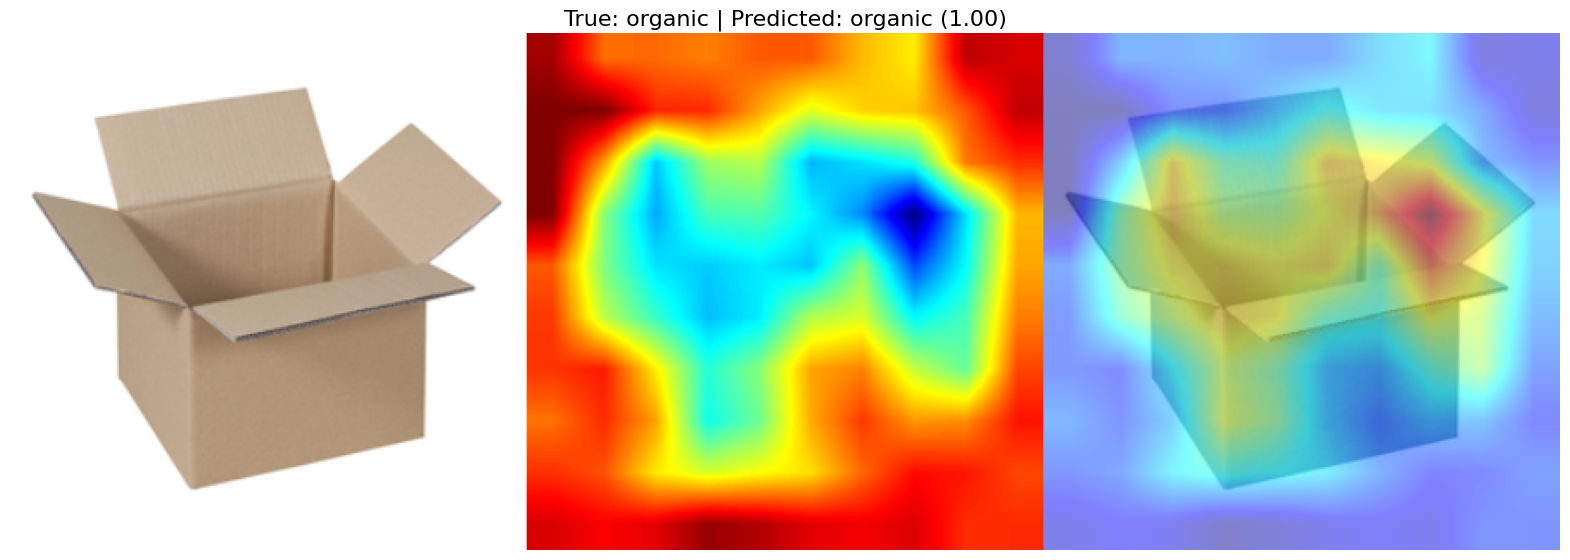

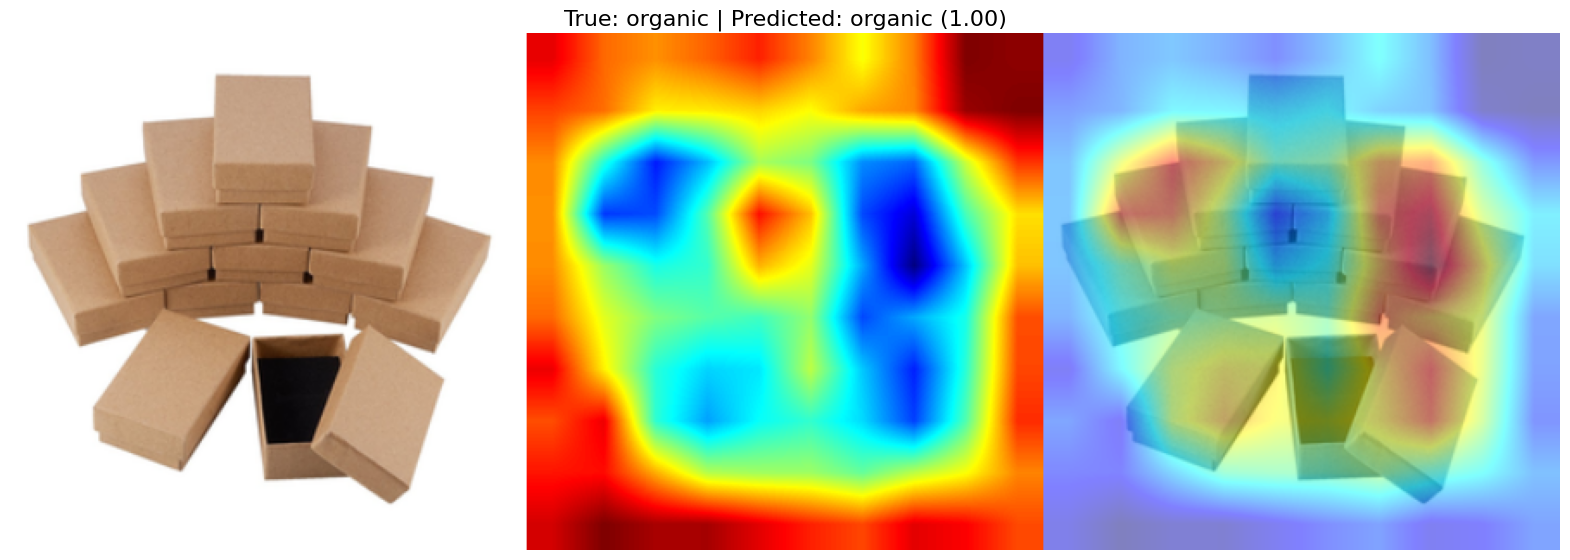

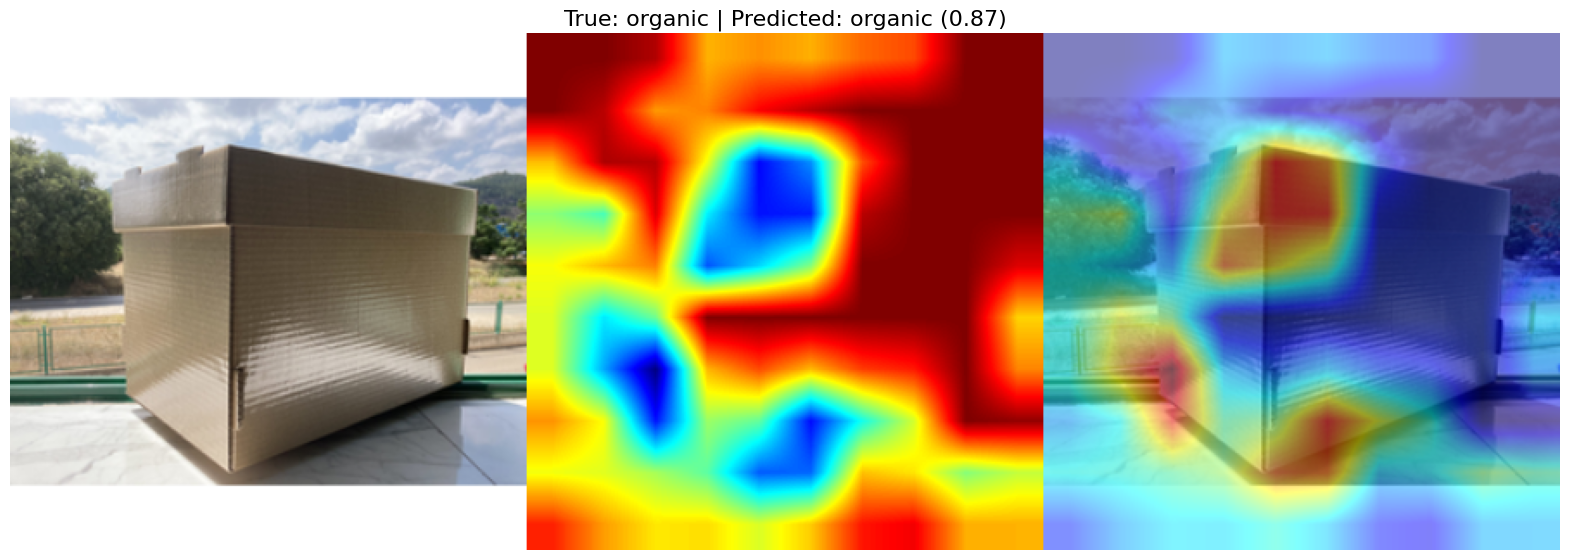

In [24]:
import random
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Create a directory to save visualizations
gradcam_output_dir = Path("./gradcam_visualizations")
gradcam_output_dir.mkdir(parents=True, exist_ok=True)

def compute_gradcam(model, images, target_layer):
    model.eval()
    gradients = []
    activations = []

    def save_gradient(grad):
        gradients.append(grad)

    handle_activations = target_layer.register_forward_hook(lambda m, i, o: activations.append(o))
    handle_gradients = target_layer.register_backward_hook(lambda m, gi, go: save_gradient(go[0]))

    images.requires_grad = True
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    loss = outputs.gather(1, preds.view(-1, 1)).sum()
    model.zero_grad()
    loss.backward()

    activations = activations[0].detach()
    gradients = gradients[0].detach()
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1, keepdim=True)
    cam = F.relu(cam)

    heatmaps = []
    for hmap in cam:
        hmap = hmap.squeeze().cpu().numpy()
        hmap = cv2.resize(hmap, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min())
        heatmaps.append(hmap)

    handle_activations.remove()
    handle_gradients.remove()
    return heatmaps

def overlay_mask(image_pil, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    image = np.array(image_pil)
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Target layer for Grad-CAM (e.g., last convolutional layer in ResNet)
target_layer = model.base_model.layer4[-1]

# Select 3 random images from the test dataset
indices = random.sample(range(len(test_dataset)), 3)
selected_images = []
selected_labels = []

for idx in indices:
    image, label = test_dataset[idx]
    selected_images.append(image)
    selected_labels.append(label)

selected_images = torch.stack(selected_images).to(device)
selected_labels = torch.tensor(selected_labels).to(device)

heatmaps = compute_gradcam(model, selected_images, target_layer)

for idx, (image, label, heatmap) in enumerate(zip(selected_images, selected_labels, heatmaps)):
    # Detach, denormalize, and convert the image to PIL
    image_np = (image.detach().cpu().numpy().transpose(1, 2, 0) * 0.5) + 0.5
    image_pil = Image.fromarray((np.clip(image_np * 255, 0, 255)).astype(np.uint8))
    overlay = overlay_mask(image_pil, heatmap)

    # Convert each component to NumPy for stacking
    image_np = np.array(image_pil)
    heatmap_np = (heatmap * 255).astype(np.uint8)
    heatmap_np = cv2.applyColorMap(heatmap_np, cv2.COLORMAP_JET)
    overlay_np = np.array(overlay)

    # Horizontally stack image, heatmap, and overlay
    horizontal_stack = np.hstack([image_np, heatmap_np, overlay_np])

    # Title with predicted class, confidence, and true label
    with torch.no_grad():
        outputs = model(image.unsqueeze(0))
        probs = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_class = class_names[pred_idx]
        confidence = probs[0, pred_idx].item()

    # Save the visualization
    output_path = gradcam_output_dir / f"sample_{idx}_visualization.png"
    cv2.imwrite(str(output_path), cv2.cvtColor(horizontal_stack, cv2.COLOR_RGB2BGR))

    # Plot for inline visualization
    fig=plt.figure(figsize=(20, 8))
    plt.imshow(horizontal_stack)
    plt.title(
        f"True: {class_names[label.item()]} | Predicted: {pred_class} ({confidence:.2f})",
        fontsize=16,
    )
    plt.axis("off")
    fig.savefig(f"/content/drive/MyDrive/ML/Waste/utilities/gradcam_visualizations/sample_{idx}_visualization.png")
    plt.show()
